<a href="https://colab.research.google.com/github/cadyngo/EAS-Math-for-AI/blob/main/09_Density_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Density Estimation with Gaussian Mixture Models (GMMs) + EM


- Gaussian mixture models (GMMs) for **density estimation**
- Maximum-likelihood learning with **responsibilities** (soft assignments)
- The **Expectation-Maximization (EM)** algorithm
- The **latent-variable** (discrete hidden variable) perspective



## Outline

1. Motivation: why one Gaussian can fail for multi-modal data  
2. Mixture models and the GMM density  
3. Maximum likelihood objective for GMMs  
4. Responsibilities (soft assignments)  
5. Parameter updates (means, covariances, mixture weights)  
6. Full EM algorithm (from scratch) + monotonic log-likelihood  
7. Latent-variable view: $z$ one-hot, joint/marginal/posterior  
8. (Optional) Comparison with `sklearn.mixture.GaussianMixture` and model selection (BIC)

In [ ]:
# Core scientific Python stack (available by default in Colab)
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import logsumexp
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

np.set_printoptions(precision=3, suppress=True)
rng = np.random.default_rng(0)

print("Imports OK")

Imports OK


## Helper functions

We will implement GMM log-densities and EM with numerically stable computations.

Key idea: compute responsibilities using the log domain

$$
\log r_{ik} \propto \log \pi_k + \log {N}(x_i\mid \mu_k, \Sigma_k)
$$

and normalize across \(k\) using `logsumexp` (softmax in log-space).

In [ ]:
def as_2d(X):
    """Ensure X is (N, D)."""
    X = np.asarray(X)
    if X.ndim == 1:
        return X[:, None]
    return X

def log_gaussian(X, mu, Sigma):
    """
    Log multivariate normal density:
      log N(x | mu, Sigma)
    for each row x in X.

    X: (N, D)
    mu: (D,)
    Sigma: (D, D) positive definite
    returns: (N,)
    """
    X = as_2d(X)
    mu = np.asarray(mu)
    Sigma = np.asarray(Sigma)

    D = X.shape[1]
    # Cholesky for stability (Sigma = L L^T)
    L = np.linalg.cholesky(Sigma)
    diff = (X - mu)

    # Solve L y = diff^T  => y = L^{-1} diff^T
    y = np.linalg.solve(L, diff.T)  # (D, N)
    maha = np.sum(y**2, axis=0)     # (N,)

    log_det = 2.0 * np.sum(np.log(np.diag(L)))
    return -0.5 * (D * np.log(2*np.pi) + log_det + maha)

def e_step(X, pis, mus, Sigmas):
    """
    E-step: compute responsibilities r_ik and log-likelihood.

    pis: (K,)
    mus: (K, D)
    Sigmas: (K, D, D)
    """
    X = as_2d(X)
    pis = np.asarray(pis)
    mus = np.asarray(mus)
    Sigmas = np.asarray(Sigmas)
    K = pis.shape[0]

    log_comp = []
    for k in range(K):
        log_comp.append(np.log(pis[k]) + log_gaussian(X, mus[k], Sigmas[k]))
    log_comp = np.stack(log_comp, axis=1)  # (N, K)

    log_norm = logsumexp(log_comp, axis=1)  # (N,)
    resp = np.exp(log_comp - log_norm[:, None])
    loglik = np.sum(log_norm)
    return resp, loglik

def m_step(X, resp, reg_covar=1e-6):
    """
    M-step updates:

      N_k = sum_i r_ik
      pi_k = N_k / N
      mu_k = (1/N_k) sum_i r_ik x_i
      Sigma_k = (1/N_k) sum_i r_ik (x_i - mu_k)(x_i - mu_k)^T

    reg_covar adds a small diagonal for numerical stability.
    """
    X = as_2d(X)
    resp = np.asarray(resp)
    N, D = X.shape
    K = resp.shape[1]

    Nk = resp.sum(axis=0) + 1e-16
    pis = Nk / N
    mus = (resp.T @ X) / Nk[:, None]

    Sigmas = np.zeros((K, D, D))
    I = np.eye(D)
    for k in range(K):
        diff = X - mus[k]
        Sigmas[k] = (resp[:, k, None] * diff).T @ diff / Nk[k]
        Sigmas[k] = Sigmas[k] + reg_covar * I

    return pis, mus, Sigmas, Nk

def em_gmm(X, K, max_iter=200, tol=1e-6, reg_covar=1e-6, seed=0):
    """Run EM for a full-covariance GMM."""
    X = as_2d(X)
    N, D = X.shape
    rng_local = np.random.default_rng(seed)

    # --- initialization ---
    idx = rng_local.choice(N, size=K, replace=False)
    mus = X[idx].copy()

    Sigma0 = np.cov(X, rowvar=False, bias=True)
    if np.ndim(Sigma0) == 0:
        Sigma0 = np.array([[Sigma0]])
    Sigmas = np.stack([Sigma0 + reg_covar*np.eye(D) for _ in range(K)], axis=0)

    pis = np.ones(K) / K

    # --- EM loop ---
    loglik_hist = []
    for it in range(max_iter):
        resp, loglik = e_step(X, pis, mus, Sigmas)
        loglik_hist.append(loglik)

        pis, mus, Sigmas, Nk = m_step(X, resp, reg_covar=reg_covar)

        if it > 0 and abs(loglik_hist[-1] - loglik_hist[-2]) < tol:
            break

    return {
        "pis": pis,
        "mus": mus,
        "Sigmas": Sigmas,
        "resp": resp,
        "loglik_hist": np.array(loglik_hist),
        "n_iter": len(loglik_hist),
    }

def gmm_pdf_1d(x, pis, mus, vars_):
    pdf = np.zeros_like(x, dtype=float)
    for k in range(len(pis)):
        pdf += pis[k] * norm.pdf(x, loc=mus[k], scale=np.sqrt(vars_[k]))
    return pdf

print("Helper functions OK")

Helper functions OK


## 1) Motivation: why one Gaussian may be insufficient

A single Gaussian can summarize a dataset by its mean and covariance, but it cannot represent **multi-modality** well.
Mixture models fix this by combining several simple distributions in a convex combination.

We'll generate a multi-cluster 2D dataset and compare:
- a **single Gaussian** fit (closed-form MLE for \(K=1\))
- a **GMM** fit (learned by EM)

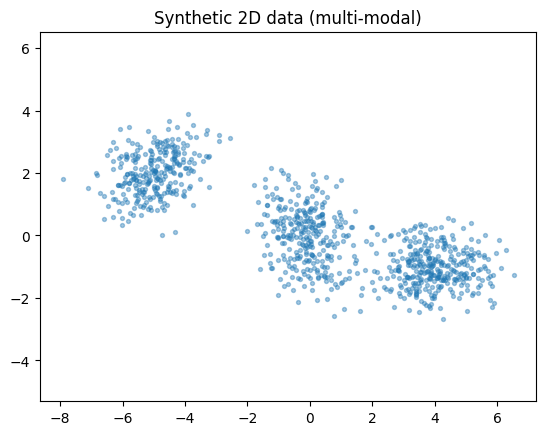

X2 shape: (900, 2)


In [ ]:
# Create a 2D, 3-cluster dataset (a sample from a 3-component GMM)
N = 900
true_pis = np.array([0.33, 0.33, 0.34])
true_mus = np.array([[-5.0,  2.0],
                     [ 0.0,  0.0],
                     [ 4.0, -1.0]])
true_Sigmas = np.array([
    [[ 0.7,  0.2],
     [ 0.2,  0.5]],
    [[ 0.6, -0.1],
     [-0.1, 0.8]],
    [[ 0.9,  0.0],
     [ 0.0,  0.4]],
])

z = rng.choice(3, size=N, p=true_pis)
X2 = np.vstack([
    rng.multivariate_normal(true_mus[k], true_Sigmas[k], size=(z == k).sum())
    for k in range(3)
])

plt.figure()
plt.scatter(X2[:, 0], X2[:, 1], s=8, alpha=0.4)
plt.title("Synthetic 2D data (multi-modal)")
plt.axis("equal")
plt.show()

print("X2 shape:", X2.shape)

Single Gaussian MLE mean: [-0.102  0.229]
Single Gaussian MLE covariance:
 [[14.103 -4.551]
 [-4.551  2.18 ]]


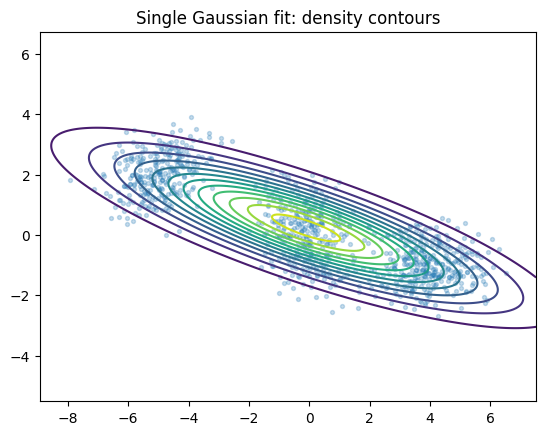

In [ ]:
# Closed-form MLE for a *single* Gaussian: sample mean and sample covariance (divide by N)
mu_hat = X2.mean(axis=0)
Sigma_hat = np.cov(X2, rowvar=False, bias=True)

print("Single Gaussian MLE mean:", mu_hat)
print("Single Gaussian MLE covariance:\n", Sigma_hat)

# Evaluate density on a grid and plot contours
x_min, x_max = X2[:,0].min() - 1.0, X2[:,0].max() + 1.0
y_min, y_max = X2[:,1].min() - 1.0, X2[:,1].max() + 1.0

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
logp = log_gaussian(grid, mu_hat, Sigma_hat)
p = np.exp(logp).reshape(xx.shape)

plt.figure()
plt.scatter(X2[:, 0], X2[:, 1], s=8, alpha=0.25)
plt.contour(xx, yy, p, levels=12)
plt.title("Single Gaussian fit: density contours")
plt.axis("equal")
plt.show()

sklearn weights: [0.326 0.368 0.306]
sklearn means:
 [[-0.108 -0.026]
 [ 3.959 -1.028]
 [-4.991  2.015]]


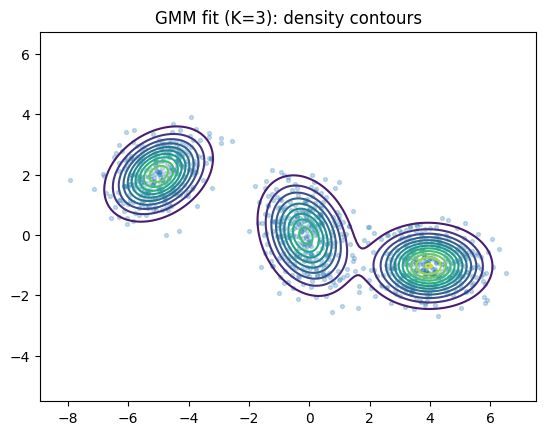

In [ ]:
# Fit a 3-component GMM via sklearn (EM under the hood)
gmm = GaussianMixture(n_components=3, covariance_type="full", random_state=0)
gmm.fit(X2)

print("sklearn weights:", np.round(gmm.weights_, 3))
print("sklearn means:\n", np.round(gmm.means_, 3))

logp_gmm = gmm.score_samples(grid)  # log p(x)
p_gmm = np.exp(logp_gmm).reshape(xx.shape)

plt.figure()
plt.scatter(X2[:, 0], X2[:, 1], s=8, alpha=0.25)
plt.contour(xx, yy, p_gmm, levels=12)
plt.title("GMM fit (K=3): density contours")
plt.axis("equal")
plt.show()

## 2) Mixture models and the Gaussian Mixture Model (GMM)

A **mixture model** is a convex combination of \(K\) base distributions:

$$
p(x) = \sum_{k=1}^K \pi_k \, p_k(x), \quad
0 \le \pi_k \le 1,\quad \sum_{k=1}^K \pi_k = 1.
$$

A **Gaussian mixture model (GMM)** uses Gaussians as the base distributions:

$$
p(x\mid \theta) = \sum_{k=1}^K \pi_k \, {N}(x\mid \mu_k, \Sigma_k),
\quad \theta=\{(\pi_k,\mu_k,\Sigma_k)\}_{k=1}^K.
$$

Concrete 1D example (from the slides):

$$
p(x) = 0.5\,{N}(x\mid -2, 0.5) + 0.2\,{N}(x\mid 1, 2) + 0.3\,{N}(x\mid 4, 1).
$$

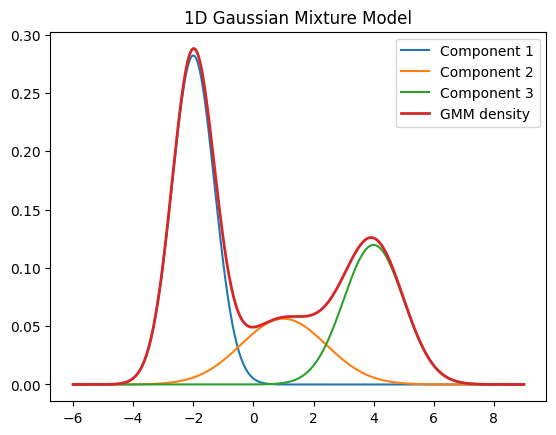

In [ ]:
# Plot the 1D GMM example density and its components
pis_ex = np.array([0.5, 0.2, 0.3])
mus_ex = np.array([-2.0, 1.0, 4.0])
vars_ex = np.array([0.5, 2.0, 1.0])

x = np.linspace(-6, 9, 400)
p_mix = gmm_pdf_1d(x, pis_ex, mus_ex, vars_ex)

plt.figure()
for k in range(3):
    pk = pis_ex[k] * norm.pdf(x, loc=mus_ex[k], scale=np.sqrt(vars_ex[k]))
    plt.plot(x, pk, label=f"Component {k+1}")
plt.plot(x, p_mix, label="GMM density", linewidth=2)
plt.title("1D Gaussian Mixture Model")
plt.legend()
plt.show()

## 3) Maximum Likelihood Estimation (MLE) for a GMM

Given a dataset \(X=\{x_1,\dots,x_N\}\) (i.i.d.), the likelihood under a GMM is

$$
p(X\mid \theta) = \prod_{i=1}^N p(x_i\mid \theta),
\quad
p(x_i\mid \theta) = \sum_{k=1}^K \pi_k {N}(x_i\mid \mu_k,\Sigma_k).
$$

So the log-likelihood is

$$
{L}(\theta)
= \sum_{i=1}^N \log\left(\sum_{k=1}^K \pi_k {N}(x_i\mid \mu_k,\Sigma_k)\right).
$$

For \(K=1\) (single Gaussian) we get a closed-form MLE (\(\hat\mu=\) sample mean, \(\hat\Sigma=\) sample covariance).
For \(K>1\), there is no closed-form solution, and we use an iterative method: **EM**.

In [ ]:
# Demonstrate computing the GMM log-likelihood numerically (stable logsumexp form)

# We'll reuse the synthetic 2D dataset X2 and the fitted sklearn GMM
pis = gmm.weights_
mus = gmm.means_
Sigmas = gmm.covariances_

resp, loglik = e_step(X2, pis, mus, Sigmas)
print("Log-likelihood (sum_i log p(x_i)):", float(loglik))
print("Average log-likelihood per point:", float(loglik) / len(X2))

# Responsibilities are probability vectors (row sums ~ 1)
print("Row-sum check (min, max):", resp.sum(axis=1).min(), resp.sum(axis=1).max())

Log-likelihood (sum_i log p(x_i)): -3094.0568262508605
Average log-likelihood per point: -3.4378409180565117
Row-sum check (min, max): 0.9999999999999996 1.0000000000000004


## 4) Responsibilities (soft assignments)

Define the **responsibility** of component \(k\) for data point \(x_i\):

$$
r_{ik}
:= \frac{\pi_k\,{N}(x_i\mid \mu_k,\Sigma_k)}{\sum_{j=1}^K \pi_j\,{N}(x_i\mid \mu_j,\Sigma_j)}.
$$

Facts:

- $r_i=[r_{i1},\dots,r_{iK}]^\top$ is a normalized probability vector.
- It is a **soft assignment** (compare to a softmax over components).
- In the latent-variable view (later), $r_{ik}=p(z_i=k\mid x_i)$.

### Example: compute responsibilities for a 1D dataset


- \(X=\{-3, -2.5, -1, 0, 2, 4, 5\}\)
- \(K=3\)
- \(p_1={N}(-4, 1)\), \(p_2={N}(0, 0.2)\), \(p_3={N}(8, 3)\)
- \(\pi_1=\pi_2=\pi_3=1/3\)

We compute \(r_{ik}\) and reproduce the table in the slides (up to rounding).

In [ ]:
X1 = np.array([-3, -2.5, -1, 0, 2, 4, 5], dtype=float)[:, None]  # (N,1)
pis0 = np.array([1/3, 1/3, 1/3], dtype=float)
mus0 = np.array([[-4.0], [0.0], [8.0]])
vars0 = np.array([1.0, 0.2, 3.0])
Sigmas0 = np.array([[[v]] for v in vars0])  # (K,1,1)

resp0, ll0 = e_step(X1, pis0, mus0, Sigmas0)
print("Responsibilities (rounded to 3 decimals):")
print(np.round(resp0, 3))

print("\nRow sums:", np.round(resp0.sum(axis=1), 6))

Responsibilities (rounded to 3 decimals):
[[1.    0.    0.   ]
 [1.    0.    0.   ]
 [0.057 0.943 0.   ]
 [0.    1.    0.   ]
 [0.    0.066 0.934]
 [0.    0.    1.   ]
 [0.    0.    1.   ]]

Row sums: [1. 1. 1. 1. 1. 1. 1.]


## 5) M-step updates (means, covariances, mixture weights)

Given responsibilities \(r_{ik}\), define the *effective number of points* in component \(k\):

$$
N_k := \sum_{i=1}^N r_{ik}.
$$

Then the standard M-step updates are:

**Means**
$$
\mu_k^{new} = \frac{1}{N_k}\sum_{i=1}^N r_{ik}\,x_i
$$

**Covariances**
$$
\Sigma_k^{new} = \frac{1}{N_k}\sum_{i=1}^N r_{ik}\,(x_i-\mu_k^{new})(x_i-\mu_k^{new})^\top
$$

**Mixture weights**
$$
\pi_k^{new} = \frac{N_k}{N}, \quad \sum_k \pi_k^{new}=1
$$

These are weighted versions of the familiar sample mean/covariance, plus the normalization constraint for \(\pi\) (often derived via a Lagrange multiplier).

In [ ]:
pis1, mus1, Sigmas1, Nk = m_step(X1, resp0, reg_covar=0.0)

print("N_k:", np.round(Nk, 6))
print("Updated means:", np.round(mus1.ravel(), 3))

vars1 = Sigmas1[:, 0, 0]
print("Updated variances:", np.round(vars1, 3))

print("Updated mixture weights:", np.round(pis1, 3))

# Compare with slide numbers (approx.)
expected_mu = np.array([-2.7, -0.4, 3.7])
expected_var = np.array([0.14, 0.44, 1.53])
expected_pi = np.array([0.29, 0.29, 0.42])

assert np.allclose(mus1.ravel(), expected_mu, atol=0.05)
assert np.allclose(vars1, expected_var, atol=0.05)
assert np.allclose(pis1, expected_pi, atol=0.05)

print("\nChecks passed: one EM M-step reproduces the slide updates (within tolerance).")

N_k: [2.057 2.009 2.934]
Updated means: [-2.701 -0.403  3.704]
Updated variances: [0.144 0.438 1.527]
Updated mixture weights: [0.294 0.287 0.419]

Checks passed: one EM M-step reproduces the slide updates (within tolerance).


## 6) The EM algorithm for GMMs

EM alternates:

- **E-step:** compute responsibilities $r_{ik}$ using current $(\pi,\mu,\Sigma)$
- **M-step:** update $(\pi,\mu,\Sigma)$ using the formulas above

A key qualitative property (highlighted in the slides): the log-likelihood is **non-decreasing** across iterations.

Iterations: 40
Final weights: [0.274 0.282 0.444]
Final means: [-2.754  4.505  0.283]
Final variances: [0.062 0.25  1.856]


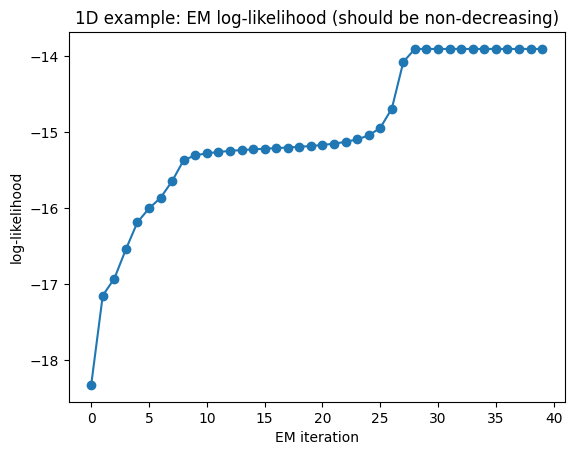

In [ ]:
# Run EM from scratch on the 1D slide dataset, starting from the slide initialization
res_1d = em_gmm(X1, K=3, max_iter=100, tol=1e-10, reg_covar=1e-8, seed=0)

print("Iterations:", res_1d["n_iter"])
print("Final weights:", np.round(res_1d["pis"], 3))
print("Final means:", np.round(res_1d["mus"].ravel(), 3))
print("Final variances:", np.round(res_1d["Sigmas"][:,0,0], 3))

# Plot log-likelihood over EM iterations
plt.figure()
plt.plot(res_1d["loglik_hist"], marker="o")
plt.title("1D example: EM log-likelihood (should be non-decreasing)")
plt.xlabel("EM iteration")
plt.ylabel("log-likelihood")
plt.show()

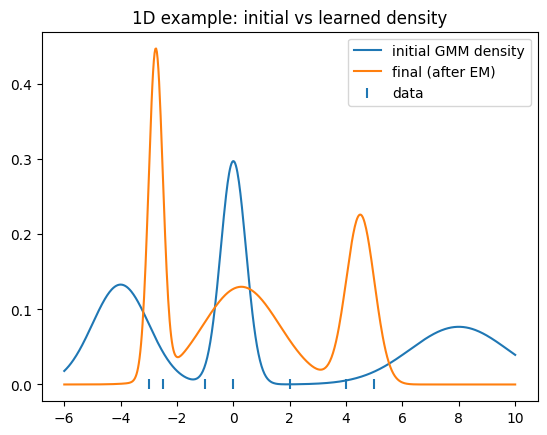

In [ ]:
# Visualize initial vs final 1D GMM density
xgrid = np.linspace(-6, 10, 600)

# initial density
p_init = gmm_pdf_1d(xgrid, pis0, mus0.ravel(), vars0)

# final density
pis_f = res_1d["pis"]
mus_f = res_1d["mus"].ravel()
vars_f = res_1d["Sigmas"][:,0,0]
p_final = gmm_pdf_1d(xgrid, pis_f, mus_f, vars_f)

plt.figure()
plt.plot(xgrid, p_init, label="initial GMM density")
plt.plot(xgrid, p_final, label="final (after EM)")
plt.scatter(X1.ravel(), np.zeros_like(X1.ravel()), s=50, marker="|", label="data")
plt.title("1D example: initial vs learned density")
plt.legend()
plt.show()

### Visualizing 2D components: covariance ellipses

In 2D, a Gaussian component can be visualized with an ellipse derived from the covariance eigenvectors/eigenvalues.
We'll fit our own EM implementation on the 2D dataset and visualize the learned components.

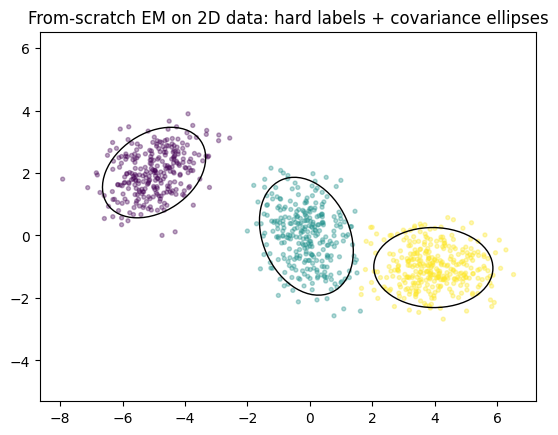

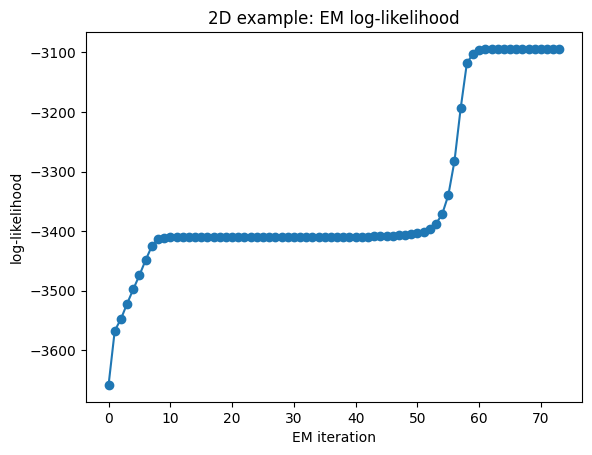

In [ ]:
from matplotlib.patches import Ellipse

def add_cov_ellipse(ax, mu, Sigma, n_std=2.0):
    """Add a covariance ellipse to ax."""
    vals, vecs = np.linalg.eigh(Sigma)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # Angle of first principal component
    angle = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))

    # Width/height = 2 * n_std * sqrt(eigenvalues)
    width, height = 2 * n_std * np.sqrt(vals)
    ell = Ellipse(xy=mu, width=width, height=height, angle=angle, fill=False)
    ax.add_patch(ell)

# Fit our from-scratch EM
res_2d = em_gmm(X2, K=3, max_iter=200, tol=1e-6, reg_covar=1e-6, seed=1)

labels = res_2d["resp"].argmax(axis=1)

fig, ax = plt.subplots()
ax.scatter(X2[:,0], X2[:,1], c=labels, s=8, alpha=0.35)
for k in range(3):
    add_cov_ellipse(ax, res_2d["mus"][k], res_2d["Sigmas"][k], n_std=2.0)
ax.set_title("From-scratch EM on 2D data: hard labels + covariance ellipses")
ax.axis("equal")
plt.show()

plt.figure()
plt.plot(res_2d["loglik_hist"], marker="o")
plt.title("2D example: EM log-likelihood")
plt.xlabel("EM iteration")
plt.ylabel("log-likelihood")
plt.show()

## 7) Latent-variable perspective

A GMM can be written as a discrete latent-variable model:

- Latent variable $z\in\{e_1,\dots,e_K\}$ is **one-hot** (exactly one component is “on”).
- Prior $p(z=k)=\pi_k$.
- Conditional $p(x\mid z=k)={N}(x\mid\mu_k,\Sigma_k)$.

Then:

**Joint**
$$
p(x, z=k) = p(z=k)\,p(x\mid z=k) = \pi_k {N}(x\mid\mu_k,\Sigma_k)
$$

**Marginal** (sum out the latent variable)
$$
p(x) = \sum_{k=1}^K p(x, z=k) = \sum_{k=1}^K \pi_k {N}(x\mid\mu_k,\Sigma_k)
$$

**Posterior** (Bayes’ rule)
$$
p(z=k\mid x)
= \frac{\pi_k {N}(x\mid\mu_k,\Sigma_k)}{\sum_{j=1}^K \pi_j {N}(x\mid\mu_j,\Sigma_j)}
= r_{k}(x)
$$

So responsibilities are mathematically the **posterior probabilities** of the latent component.

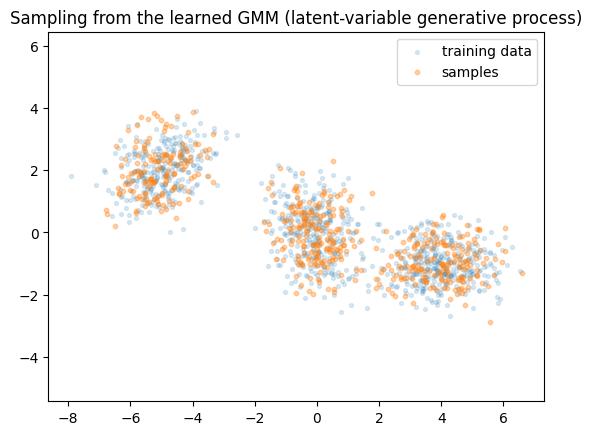

Test points:
 [[-5.  2.]
 [ 0.  0.]
 [ 4. -1.]
 [ 2.  2.]]
Posterior p(z=k|x) (responsibilities):
 [[1.   0.   0.  ]
 [0.   1.   0.  ]
 [0.   0.   1.  ]
 [0.   0.99 0.01]]


In [ ]:
# Ancestral sampling from a learned GMM:
# 1) z ~ Categorical(pis)
# 2) x ~ N(mu_z, Sigma_z)

pis_s = res_2d["pis"]
mus_s = res_2d["mus"]
Sigmas_s = res_2d["Sigmas"]

M = 500
z_samp = rng.choice(3, size=M, p=pis_s)
X_samp = np.vstack([
    rng.multivariate_normal(mus_s[k], Sigmas_s[k], size=(z_samp == k).sum())
    for k in range(3)
])

plt.figure()
plt.scatter(X2[:,0], X2[:,1], s=8, alpha=0.15, label="training data")
plt.scatter(X_samp[:,0], X_samp[:,1], s=10, alpha=0.35, label="samples")
plt.title("Sampling from the learned GMM (latent-variable generative process)")
plt.axis("equal")
plt.legend()
plt.show()

# Posterior p(z=k|x) for a few points = responsibilities
test_points = np.array([[-5, 2], [0, 0], [4, -1], [2, 2]], dtype=float)
resp_test, _ = e_step(test_points, pis_s, mus_s, Sigmas_s)
print("Test points:\n", test_points)
print("Posterior p(z=k|x) (responsibilities):\n", np.round(resp_test, 3))

## 8) (Optional) Choosing \(K\) with BIC

The slides focus on learning parameters given \(K\). In practice, you often also want to choose \(K\).

One common criterion is BIC (Bayesian Information Criterion). Lower is better:

$$
\mathrm{BIC} = -2\,\log p(X\mid \hat\theta) + (\#\text{params})\log N
$$

We'll compute BIC for several \(K\) and look for the minimum.

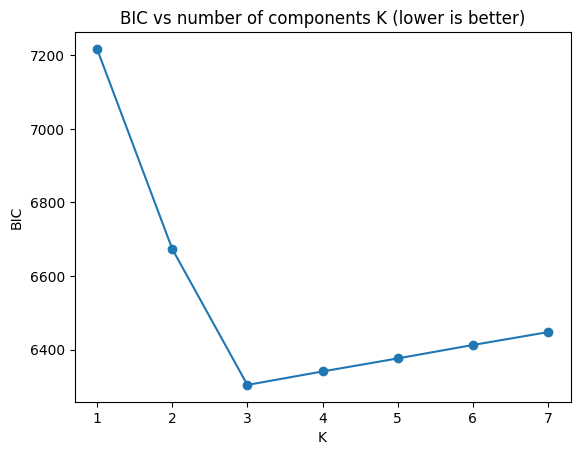

Best K by BIC (in this sweep): 3


In [ ]:
Ks = range(1, 8)
bics = []
for K in Ks:
    gm = GaussianMixture(n_components=K, covariance_type="full", random_state=0)
    gm.fit(X2)
    bics.append(gm.bic(X2))

plt.figure()
plt.plot(list(Ks), bics, marker="o")
plt.title("BIC vs number of components K (lower is better)")
plt.xlabel("K")
plt.ylabel("BIC")
plt.show()

bestK = list(Ks)[int(np.argmin(bics))]
print("Best K by BIC (in this sweep):", bestK)

#  Exercises

**How to use**
1. Run the **Setup** cell once.
2. Work through Exercises 1–3 in order.
3. Each exercise has small `assert` checks so you get immediate feedback.


In [ ]:
# Setup (run once)
import numpy as np

# Toy dataset and initialization (matches the slide example)
X_ex = np.array([-3, -2.5, -1, 0, 2, 4, 5], dtype=float).reshape(-1, 1)  # (N,1)
mu_ex = np.array([-4.0, 0.0, 8.0])                                      # (K,)
sigma2_ex = np.array([1.0, 0.2, 3.0])                          # (K,) variances
pi_ex = np.array([1/3, 1/3, 1/3], dtype=float)                         # (K,)

N_ex = X_ex.shape[0]
K_ex = mu_ex.shape[0]

def gaussian_pdf_1d(x, mu, var):
    """1D Gaussian pdf N(x | mu, var). x can be shape (N,1) or (N,)."""
    x = np.asarray(x).reshape(-1)
    coef = 1.0 / np.sqrt(2.0 * np.pi * var)
    return coef * np.exp(-0.5 * ((x - mu) ** 2) / var)

def gmm_log_likelihood_1d(X, mu, var, pi):
    """Numerically stable log-likelihood sum_i log(sum_k pi_k N(x_i|mu_k,var_k))."""
    x = np.asarray(X).reshape(-1, 1)       # (N,1)
    mu = np.asarray(mu).reshape(1, -1)     # (1,K)
    var = np.asarray(var).reshape(1, -1)   # (1,K)
    pi = np.asarray(pi).reshape(1, -1)     # (1,K)

    log_comp = np.log(pi) - 0.5 * (np.log(2.0 * np.pi * var) + (x - mu) ** 2 / var)  # (N,K)

    # logsumexp over components (stable)
    m = log_comp.max(axis=1, keepdims=True)
    log_px = m + np.log(np.exp(log_comp - m).sum(axis=1, keepdims=True))
    return float(log_px.sum())

print(f"N_ex={N_ex}, K_ex={K_ex}")
print("X_ex:", X_ex.ravel().tolist())
print("mu_ex:", mu_ex)
print("sigma2_ex:", sigma2_ex)
print("pi_ex:", pi_ex, "(sum=", pi_ex.sum(), ")")


N_ex=7, K_ex=3
X_ex: [-3.0, -2.5, -1.0, 0.0, 2.0, 4.0, 5.0]
mu_ex: [-4.  0.  8.]
sigma2_ex: [1.  0.2 3. ]
pi_ex: [0.333 0.333 0.333] (sum= 1.0 )


## Exercise 1 — E-step: Responsibilities

In a GMM, the **responsibility** of component *k* for data point *x_i* is:

$$
r_{ik} = \frac{\pi_k\, {N}(x_i\mid \mu_k, \sigma_k^2)}{\sum_j \pi_j\, {N}(x_i\mid \mu_j, \sigma_j^2)}
$$

In code, you typically compute the numerator for all components and then **normalize across components**.

**Task (add 1 line):** compute the normalized responsibility matrix `R` so that each row sums to 1.


In [ ]:
# Exercise 1: compute responsibilities R (N_ex x K_ex)

# Component densities N(x_i | mu_k, sigma2_k) for all i,k
dens = np.stack([gaussian_pdf_1d(X_ex, mu_ex[k], sigma2_ex[k]) for k in range(K_ex)], axis=1)  # (N,K)

# Unnormalized responsibilities: pi_k * N(x_i | ...)
unnorm = dens * pi_ex  # (N,K) via broadcasting

# TODO (1 line): normalize across components to obtain responsibilities R.
# Hint: use keepdims=True so the division broadcasts correctly.
R = None

# --- checks (should pass once R is correct) ---
assert R is not None, "Set R to a (N_ex, K_ex) numpy array."
assert R.shape == (N_ex, K_ex), f"Expected R shape {(N_ex, K_ex)}, got {R.shape}."
assert np.allclose(R.sum(axis=1), 1.0), "Each row of responsibilities must sum to 1."

# A couple of targeted sanity checks (approx values for this toy setting)
# x=-1 is mostly component 2; x=2 is split between components 2 and 3.
assert abs(R[2, 0] - 0.05707) < 1e-3
assert abs(R[2, 1] - 0.94293) < 1e-3
assert abs(R[4, 1] - 0.06624) < 1e-3
assert abs(R[4, 2] - 0.93375) < 1e-3

print("Passed: responsibilities look correct.")
print(np.round(R, 6))


## Exercise 2 — M-step: Update the Means

Given responsibilities, the M-step mean update is the **responsibility-weighted average**:

$$
\mu_k^{new} = \frac{\sum_i r_{ik} x_i}{\sum_i r_{ik}}\quad\text{where}\quad N_k = \sum_i r_{ik}
$$

**Task (add 2 lines):**
1. Compute `Nk` (shape `(K_ex,)`)
2. Compute `mu_new` (shape `(K_ex,)`)


In [ ]:
# Exercise 2: update means mu_new using responsibilities R

# TODO (1 line): Nk = sum_i r_ik for each component (shape: (K_ex,))
Nk = None

# TODO (1 line): mu_new = (sum_i r_ik x_i) / Nk  (shape: (K_ex,))
mu_new = None

# --- checks ---
assert Nk is not None and mu_new is not None, "Set Nk and mu_new."
assert Nk.shape == (K_ex,), f"Expected Nk shape {(K_ex,)}, got {Nk.shape}."
assert mu_new.shape == (K_ex,), f"Expected mu_new shape {(K_ex,)}, got {mu_new.shape}."

assert np.isclose(Nk.sum(), N_ex), "Sum_k Nk should equal N_ex."

target_mu = np.array([-2.7012, -0.4034, 3.7043])
assert np.allclose(mu_new, target_mu, atol=1e-3), f"Expected approx {target_mu}, got {mu_new}."

print("Passed: mean update is correct.")
print("Nk:", Nk)
print("mu_new:", mu_new)


## Exercise 3 — M-step: Update Variances and Mixture Weights + Check Likelihood

For the 1D case, the covariance update becomes a variance update:
$$
\sigma_k^{2\,new} = \frac{1}{N_k}\sum_i r_{ik}(x_i-\mu_k^{new})^2
$$

The mixture weights update is:

$$
\pi_k^{new} = \frac{N_k}{N}
$$

**Task (add 2 lines):**
1. Compute `sigma2_new` (shape `(K_ex,)`)
2. Compute `pi_new` (shape `(K_ex,)`, sums to 1)

Then we verify that the **log-likelihood increases** after this EM iteration (a key EM property mentioned in the slides).


In [ ]:
# Exercise 3: update variances sigma2_new and mixture weights pi_new

# TODO (1 line): sigma2_new = (1/Nk) * sum_i r_ik * (x_i - mu_new_k)^2
sigma2_new = (R * (X_ex.reshape(-1,1) - mu_new.reshape(1,-1))**2).sum(axis=0) / Nk

# TODO (1 line): pi_new = Nk / N_ex
pi_new = None

# --- checks ---
assert sigma2_new is not None and pi_new is not None, "Set sigma2_new and pi_new."
assert sigma2_new.shape == (K_ex,), f"Expected sigma2_new shape {(K_ex,)}, got {sigma2_new.shape}."
assert pi_new.shape == (K_ex,), f"Expected pi_new shape {(K_ex,)}, got {pi_new.shape}."
assert np.allclose(pi_new.sum(), 1.0), "Mixture weights must sum to 1."

target_sigma2 = np.array([0.1440, 0.4385, 1.5266])
target_pi = np.array([0.2939, 0.2870, 0.4191])
assert np.allclose(sigma2_new, target_sigma2, atol=1e-3), f"Expected approx {target_sigma2}, got {sigma2_new}."
assert np.allclose(pi_new, target_pi, atol=1e-3), f"Expected approx {target_pi}, got {pi_new}."

# Likelihood should improve after one EM iteration
ll_before = gmm_log_likelihood_1d(X_ex, mu_ex, sigma2_ex, pi_ex)
ll_after  = gmm_log_likelihood_1d(X_ex, mu_new, sigma2_new, pi_new)
print(f"log-likelihood before: {ll_before:.6f}")
print(f"log-likelihood after : {ll_after:.6f}")
assert ll_after >= ll_before - 1e-10, "Log-likelihood did not increase; re-check updates."

print("Passed: variance + weight updates correct, and likelihood increased.")
print("sigma2_new:", sigma2_new)
print("pi_new:", pi_new)
